In [1]:
import shapely
from shapely.geometry import box, MultiPolygon, LineString, Point, MultiLineString, Polygon
import math
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from gridmap import OccupancyGridMap
import matplotlib.pyplot as plt
from a_star import a_star
from utils import plot_path
from sklearn import preprocessing
import pandas as pd
from tqdm import tqdm

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score, train_test_split
import random
from tqdm import tqdm


import warnings
warnings.filterwarnings('ignore')

C:\Users\joega\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
pi = math.pi
def PointsInCircum(r,n=360, center = (0,0)):
    return np.array([(center[0] + math.cos(2*pi/n*x)*r, center[1] + math.sin(2*pi/n*x)*r) for x in range(0,n+1)])

In [3]:
def gen_shapely_map(map_size, obstacles):
    '''
    Given map_size and list of obstacles where
    an obstacle is described by a tuple (xmin, ymin, xmax, ymax),
    create a shapely map. 
    '''
    
    pols = [box(0,0,map_size[0], map_size[1])]
    for obstacle in obstacles:
        pols.append(box(*obstacle))
    lines = []
    for pol in pols:
        boundary = pol.boundary
        if boundary.type == 'MultiLineString':
            for line in boundary:
                lines.append(line)
        else:
            lines.append(boundary)

    MAP = MultiLineString(lines)
    return MAP

def get_map_arr(MAP_params, shape):
    '''
    Convert the shapely obstacles into a numpy grid
    for use with the A* planner. 
    
    MAP_params is of the form [(xmin, ymin, xmax, ymax), (xmin, ymin, xmax, ymax), ...]
    describing each rectangular obstacle in the map. Currently only supports rectangles. 
    
    Shape is just a tuple with the map size. 
    
    '''
    map_np = np.zeros(shape)
    for param in MAP_params:
        xmin, ymin, xmax, ymax = param
        map_np[ymin:ymax, xmin:xmax] = 1
        
    return map_np

In [4]:
def synthetic_sensor(MAP, robot_location):
    '''
    Given a shapely map and the robots current location, 
    return the 360 degree laser scanner. 
    '''
    lines = []
    # 100 is arbitrary radius. Just needs to be big enough to draw line across map. 
    points = PointsInCircum(100, center = robot_location)
    # Create line to all points on circle
    for point in points:
        A = Point(robot_location)
        B = Point(point)
        line = LineString([A,B])
        lines.append(line)
        
    # Get points of intersection. 
    for i, line in enumerate(lines):
        # These two types of objects signify multiple intersections. 
        if type(MAP.intersection(line)) == shapely.geometry.multilinestring.MultiLineString or \
               type(MAP.intersection(line)) == shapely.geometry.multipoint.MultiPoint:
            # Get the closest point
            temp_dist = []
            for point in MAP.intersection(line):
#                 try:
                temp_dist.append(LineString([robot_location, point]).length)
            inter = MAP.intersection(line)[np.argmin(temp_dist)]
        # This signifies no intersection. Wont happen on current map. 
        elif type(MAP.intersection(line)) == shapely.geometry.collection.GeometryCollection:
            continue 
        # One intersection
        else:
            inter = MAP.intersection(line)
        # Create new point and update end point in list of lines. 
        new_point = (inter.xy[0][0], inter.xy[1][0])
        lines[i].coords = [robot_location, new_point]
    
    # Get lase scan data (distances)
    distances = [line.length for line in lines]
    return distances[:360]
    

In [5]:
def plot(MAP, robot_location, line_strings = None, plot_lines=False):
    '''
    This plot function is used to show the laser scan lines. 
    Current not used. Probably will be helpful when creating visualizations. 
    '''
    fig = plt.figure(frameon=False)
    fig.set_size_inches(50,50)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    for index, l in enumerate(MAP): 
        if index != 0:
            ax.fill(*l.xy, alpha=1)
        else:
            ax.plot(*l.xy, alpha=1)
    if plot_lines:
        for line in line_strings:
            ax.plot(*line.xy, alpha=0.25)
    ax.scatter(*robot_location, s=30, alpha=1.0)

In [6]:
def get_path(start, goal, arr, plot = True):
    '''
    Given start (x,y) and goal (x,y) use numpy grid arr
    to solve for best path with A*. 
    
    By default, plot the A* path everytime this is called. 
    '''
    resolution = 1
    gmap = OccupancyGridMap(arr, resolution)

    # 4n = 4 point connectivity. 8N = 8 point connectivity
    path, path_px = a_star(start, goal, gmap, movement='4N')
    if plot:
        gmap.plot()
        plot_path(path_px)
    return path

In [7]:
def plot_path_(MAP, robot_location, goal_location, path):
    '''
    Plot path on map using shapely. Not currently used. 
    '''
    fig = plt.figure(frameon=False)
    fig.set_size_inches(6,6)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    fig.add_axes(ax)
    
    for index, l in enumerate(MAP): 
        if index != 0:
            ax.fill(*l.xy, alpha=1)
        else:
            ax.plot(*l.xy, alpha=1)
    
    ax.plot(*LineString(path).xy)
    ax.scatter(robot_location[0], robot_location[1], s=30, alpha=1.0) 
    ax.scatter(goal_location[0], goal_location[1], s=30, alpha=1.0) 

In [8]:
def synthesize_data(start, goal, MAP, map_arr):
    '''
    synthesize data for one step. 
    
    -Given start and goal, we first get the A* ground truth path. 
    -If get_path() returns an error, that means there was no path found. 
    -For each element in the path, use the synthetic sensor to get the readings 
        the relative goal in odom, and the target movement
    '''
    
    # Get path if one is available
    try:
        path = get_path(start, goal, map_arr, False)
    except:
        return
    
    sensor_readings = []
    relative_goals = []
    directions = []
    prev = start
    for i, loc in enumerate(path):
        # Get laser scan
        sensor_readings.append(synthetic_sensor(MAP, loc))
        # Get goal in odom
        relative_goals.append((goal[0]-loc[0], goal[1]-loc[1]))
        # Get movement to next cell
        directions.append((loc[0] - prev[0], loc[1] - prev[1]))
        prev=loc
    return np.array(sensor_readings), np.array(relative_goals), directions, path

In [9]:
def synthesize_train_set(MAP, map_arr, num_runs = 300):
    '''
    -Get 'num_runs' different start/goal locations inside the map
    -If path is available, get training data for a given path
    -Return pandas dataframe where first 360 columns are sensor data, cols
     361 and 362 are odom info and then last 2 columns are x,y movement directions. 
    '''
    
    df = []
    
    for i in tqdm(range(num_runs)):
        # TODO: Generalize to any map shape
        start = (random.randint(1,49), random.randint(1,49))
        goal = (random.randint(1,49), random.randint(1,49))
        # If path is available, get training info
        try:
            (sensor_readings, relative_goals, directions, path) = synthesize_data(start, goal, MAP, map_arr)
            train = np.concatenate((sensor_readings, relative_goals, directions), axis=1)
            df.append(train)
        except:
            # No path found
            continue
    return pd.DataFrame(np.vstack(df))


In [10]:
def make_tuple(x):
    '''
    Function used to turn 2 pandas columns into
    a tuple in one column. See create_classification_problem
    for use. 
    '''
    return (x.iloc[0], x.iloc[1])

def create_classification_problem(df, one_hot = False):
    '''
    Now that training data has been synthesized, 
    prepare data for use with ML model. 
    '''
    
    # Turn (x,y) target into into string tuple
    # so we can then use label encoding to turn
    # this into a classification problem. 
    df['out'] = df[[362,363]].apply(make_tuple, axis=1)
    df['out'] = df['out'].astype(str)
    
    # Drop the sample where we are at the target location. 
    # We don't want to learn to stay still. 
    df = df[df['out']!='(0.0, 0.0)']
 
    # Label encode targets
    enc = preprocessing.LabelEncoder()
    df['out'] = enc.fit_transform(df['out'])
    
    # Added one-hot encoding option which
    # may be neccessary for some models
    if one_hot:
        ohe = preprocessing.OneHotEncoder(sparse=False)
        ohe.fit(df['out'].values.reshape(-1,1)) 
        df['out'] = df['out'].apply(lambda x : ohe.transform(x))
        df['out'] = df['out'].apply(lambda x : x[0])
    
    # Drop the (x,y) target columns, which have now
    # been label encoded. 
    df.drop([362, 363], axis=1, inplace=True)
    
    return df


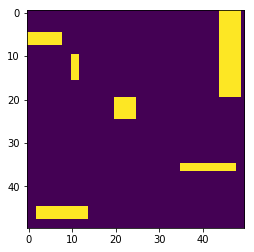

In [11]:
# Map obstacles for training map. 
map_params = [(10, 10, 12, 16), (35,35,48,37), (0,5,8,8), (20,20,25,25), (40,11,49,4), (2,45,14,48), (44,0,49,20)]
map_size = (50,50)
# Gen training map
train_MAP = gen_shapely_map(map_size, map_params)
# Convert to numpy array for A*
arr = get_map_arr(map_params, map_size)
plt.imshow(arr)

In [12]:
# Create training data
df_ = synthesize_train_set(train_MAP, arr)

# Prep data for modeling
df = create_classification_problem(df_.copy()) 
# Shuffle data (otherwise model can cheat and memorize order since these are no iid)
df = df.sample(frac=1)
# Get training acc
print(cross_val_score(RandomForestClassifier(), df.drop(['out'], axis=1).values, df['out'].values, cv=10, scoring = 'accuracy'))

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [50:25<00:00, 10.08s/it]


[0.79708384 0.80072904 0.8163017  0.83434836 0.77953715 0.77101096
 0.82926829 0.7695122  0.76434676 0.7997558 ]


In [13]:
# Fit model using all data.
clf = RandomForestClassifier(max_depth=10)
clf.fit(df.drop(['out'], axis=1).values, df['out'].values)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [40]:
'''
Testing Env:

Now we use trained model to nav unseen map. 
'''

# Mapping from label encoder (just hard coded it here)
dirs = {0:(-1.0, 0.0), 1:(0.0, -1.0), 2:(0.0, 1.0), 3:(1.0, 0.0)}
# Create new map with different obstacles
map_params = [(20, 20, 22, 29), (30,40,40,50), (0,5,8,8)]
test_MAP = gen_shapely_map((50,50), map_params)
arr = get_map_arr(map_params, (50,50))


def test_on_new_map(test_MAP, test_arr, start, goal, model):
    
    '''
    Test model performance on unseen map. 
    
    test_MAP = shapely map
    test_arr = numpy grid of mapll
    
    start,goal = (x,y), (x,y)
    model = trained sklearn model 
    '''
    
    # Get ground-truth path
    groud_truth = get_path(start, goal, test_arr) 
    print("Number of steps taken in A* Path, ", len(groud_truth))
    
    # i counter just helps stop after a certain number of steps since
    # at the moment the algorithm probably wont reach the goal. 
    i=0
    # Start saving the path traveled
    pred_path = [start]
    
    cur = start
    while cur != goal:
        # Get the laser_scan data for the current point
        laser_scan = synthetic_sensor(test_MAP, cur)
        # Add the odom frame goal to the array
        laser_scan.append(goal[0]-cur[0])
        laser_scan.append(goal[1]-cur[1])
        # Create model input
        inpX = np.array(laser_scan)
        # Get predicted direction
#         ind = clf.predict(inpX.reshape(1,-1))[0]
        inds = clf.predict_proba(inpX.reshape(1,-1))[0]
        best = list(np.argsort(inds))
        best.reverse()
        
        possible_next_states = [(cur[0] + dirs[ind][0], cur[1] + dirs[ind][1]) for ind in best]
        for state in possible_next_states:
            if -1 in state or 50 in state or state in pred_path:
                possible_next_states.remove(state)
        
        # Update state
        cur = possible_next_states[0]
        pred_path.append(cur)
        # Cout number of steps traveled 
        i+=1
        if i==100:
            break
    
    return pred_path 
    

A* Path


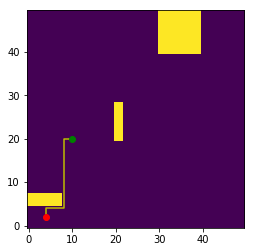

Number of steps taken in A* Path,  25


In [41]:
print("A* Path")
pred_path = test_on_new_map(test_MAP, arr, (4,2), (10,20), clf)

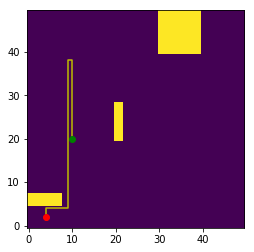

In [42]:
OccupancyGridMap(arr, 1).plot()
plot_path(pred_path)

In [18]:
# Backup Code, was trying to pick second best option if we hit a wall/obstacle 

#         prediction_probs = list(clf.predict_proba(inpX.reshape(1,-1))[0])
#         while len(prediction_probs) > 0:
#             best_dir = np.argmax(prediction_probs)
#             next_cell_dir = dirs[best_dir]        
#             t_cur = (cur[0]-next_cell_dir[0], cur[1]-next_cell_dir[1])
#             if any(ele < 0 for ele in t_cur) or any(ele > 50 for ele in t_cur):
#                 prediction_probs.remove(max(prediction_probs))
#             else:
#                 break
#         print(best_dir) 
#         cur = t_cur